
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2884
Number of nonzeros in inequality constraint Jacobian.:     1199
Number of nonzeros in Lagrangian Hessian.............:     1916

Total number of variables............................:     1206
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      726
Total number of inequality c

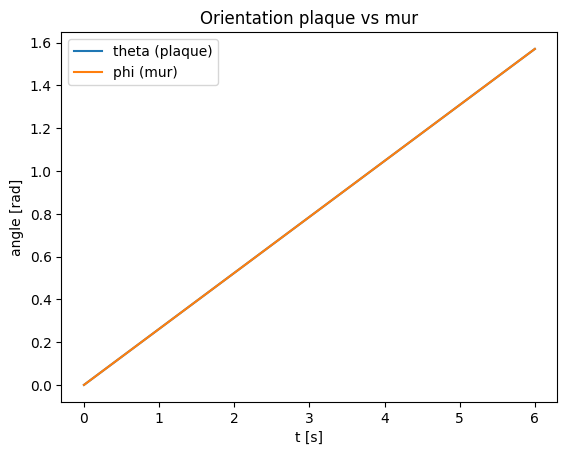

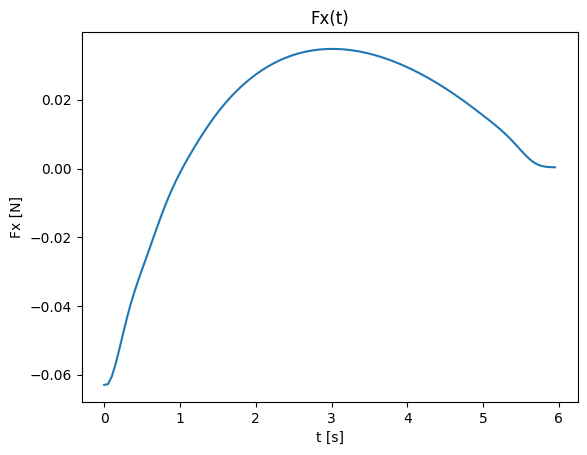

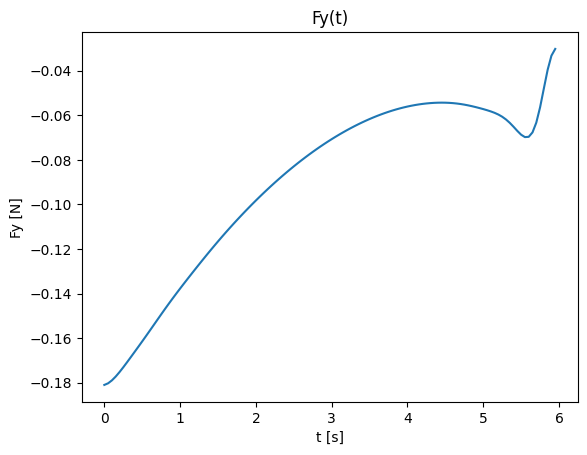

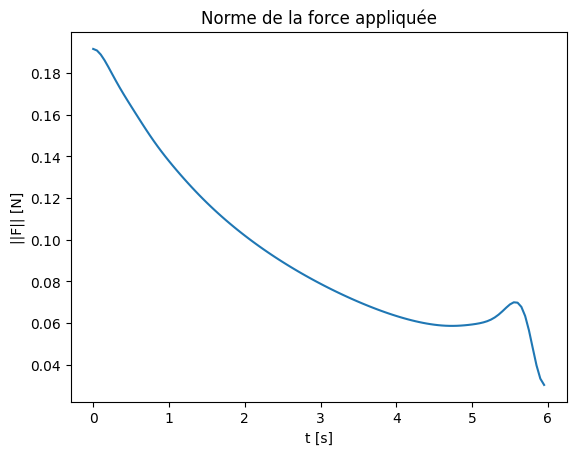

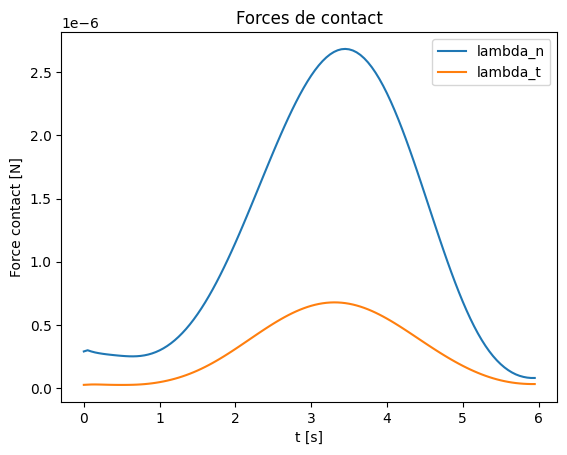

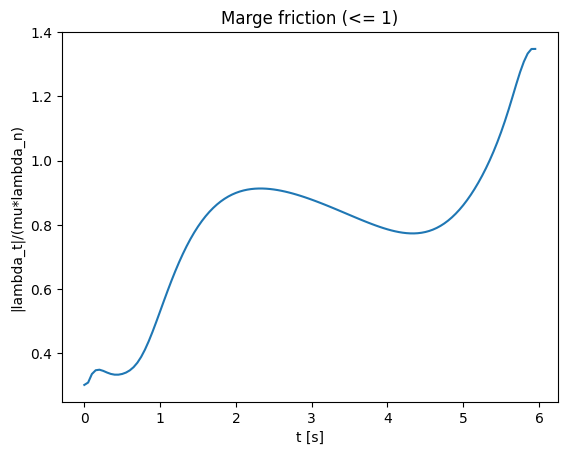

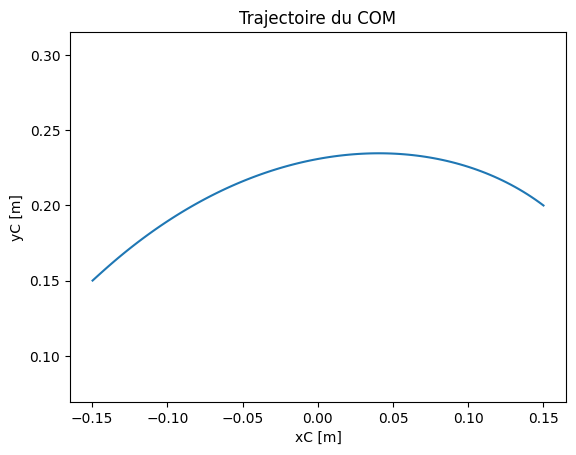

A(0) = 0.0 0.0


: 

In [ ]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt


def rot_np(angle: float) -> np.ndarray:
    c = np.cos(angle)
    s = np.sin(angle)
    return np.array([[c, -s],
                     [s,  c]], dtype=float)


def solve_ocp_contact_sticking_with_wall_guess():
    a = 0.300   # m
    b = 0.400   # m
    m = 7.0     # kg
    mu = 0.3
    Fmax = 40.0 # N

    T = 6.0
    dt = 0.05
    N = int(T / dt)
    phi0 = 0.0
    phiT = +np.pi / 2
    Omega = (phiT - phi0) / T 

    Pw = np.array([0.0, 0.0], dtype=float) 

    #inertia around pivot
    Icom = (m / 3.0) * (a*a + b*b)

    
    rA_b = np.array([-a/2.0, -b/2.0], dtype=float)

    # -----------------------
    # Tuning parameters
    # -----------------------
    q_theta = 1000.0        
    q_u = 1e-3          
    q_du = 1e-2         
    q_lam = 1e2        
    qT_theta = 20.0
    qT_omega = 50.0
    q_gap = 1e3
    q_comp = 1e3  # à ajuster


    u0 = 0.0  # m (ajustable)

    tgrid = np.linspace(0.0, T, N+1)
    phi_guess = phi0 + Omega * tgrid
    theta_guess = phi_guess.copy()
    omega_guess = np.ones(N+1) * Omega

    pA_guess = np.zeros((N+1, 2), dtype=float)
    pC_guess = np.zeros((N+1, 2), dtype=float)
    vC_guess = np.zeros((N+1, 2), dtype=float)

    for k in range(N+1):
        ph = phi_guess[k]
        # Tangente wall: t(phi) = [-sin(phi), cos(phi)]  (phi=0 => vertical +y)
        tvec = np.array([-np.sin(ph), np.cos(ph)], dtype=float)
        pA_guess[k, :] = Pw + u0 * tvec

        Rk = rot_np(theta_guess[k])
        pC_guess[k, :] = pA_guess[k, :] - (Rk @ rA_b)

    # vitesses du COM par différences finies
    vC_guess[1:, :] = (pC_guess[1:, :] - pC_guess[:-1, :]) / dt
    vC_guess[0, :] = vC_guess[1, :]

    # -----------------------
    # CasADi Opti
    # -----------------------
    opti = ca.Opti()

    # states : (xC, yC, theta, vx, vy, omega) on N+1
    xC = opti.variable(N+1)
    yC = opti.variable(N+1)
    th = opti.variable(N+1)
    vx = opti.variable(N+1)
    vy = opti.variable(N+1)
    om = opti.variable(N+1)

    #input
    Fx = opti.variable(N)
    Fy = opti.variable(N)

    
    lam_n = opti.variable(N)
    lam_t = opti.variable(N)

    # -----------------------
    # Initial constraints
    # -----------------------
    opti.subject_to(xC[0] == float(pC_guess[0, 0]))
    opti.subject_to(yC[0] == float(pC_guess[0, 1]))
    opti.subject_to(th[0] == float(theta_guess[0]))
    opti.subject_to(vx[0] == float(vC_guess[0, 0]))
    opti.subject_to(vy[0] == float(vC_guess[0, 1]))
    opti.subject_to(om[0] == float(omega_guess[0]))

    # -----------------------
    # Functions
    # -----------------------
    def Rot(angle):
        c = ca.cos(angle)
        s = ca.sin(angle)
        return ca.vertcat(
            ca.horzcat(c, -s),
            ca.horzcat(s,  c)
        )

    J = 0

    for k in range(N):
        tk = tgrid[k]
        phi_k = phi0 + Omega * tk

        
        tvec = ca.vertcat(-ca.sin(phi_k), ca.cos(phi_k))  # tangent
        nvec = ca.vertcat( ca.cos(phi_k), ca.sin(phi_k))  # normal 

        # Rotation crate
        Rk = Rot(th[k])

        
        pCk = ca.vertcat(xC[k], yC[k])
        rA_world = Rk @ ca.DM(rA_b)     
        pAk = pCk + rA_world

        
        vCk = ca.vertcat(vx[k], vy[k])
        vAk = vCk + om[k] * ca.vertcat(-rA_world[1], rA_world[0])

        
        rWk = pAk - ca.DM(Pw)
        vWk = Omega * ca.vertcat(-rWk[1], rWk[0])

        vrel = vAk - vWk

        # -----------------------
        # Contact constraints
        # -----------------------
        gk = nvec.T @ (pAk - ca.DM(Pw))
        opti.subject_to(gk >= 0)
        # Keep contact between crate and wall
        J += q_gap * gk**2

        # no slip: relative speed = 0 
        # opti.subject_to(tvec.T @ vrel == 0)
        # opti.subject_to(nvec.T @ vrel == 0)

        # Coulomb friction 
        opti.subject_to(lam_n[k] >= 0)
        opti.subject_to(lam_t[k] <=  mu * lam_n[k])
        opti.subject_to(lam_t[k] >= -mu * lam_n[k])
        J += q_comp * (lam_n[k] * gk)**2

        # max applicable force
        opti.subject_to(Fx[k]**2 + Fy[k]**2 <= Fmax**2)

        # contact force on the crate
        Fc = lam_n[k] * nvec + lam_t[k] * tvec

        # -----------------------
        # Dynamic
        # -----------------------
        # COM translation: m aC = F + Fc
        axk = (Fx[k] + Fc[0]) / m
        ayk = (Fy[k] + Fc[1]) / m

        opti.subject_to(xC[k+1] == xC[k] + dt * vx[k])
        opti.subject_to(yC[k+1] == yC[k] + dt * vy[k])
        opti.subject_to(vx[k+1] == vx[k] + dt * axk)
        opti.subject_to(vy[k+1] == vy[k] + dt * ayk)

        tau_c = rA_world[0] * Fc[1] - rA_world[1] * Fc[0]
        alphak = tau_c / Icom

        opti.subject_to(th[k+1] == th[k] + dt * om[k])
        opti.subject_to(om[k+1] == om[k] + dt * alphak)

        # -----------------------
        # Cost function 
        # -----------------------
        # Tracking léger vers la cinématique imposée du mur
        J += q_theta * (th[k] - phi_k)**2

        # Effort + lissage
        J += q_u * (Fx[k]**2 + Fy[k]**2)
        if k < N-1:
            J += q_du * ((Fx[k+1] - Fx[k])**2 + (Fy[k+1] - Fy[k])**2)

        # Régularisation très légère sur lambdas (stabilise)
        J += q_lam * (lam_n[k]**2 + lam_t[k]**2)


    # final position 
    phi_end = phi0 + Omega * tgrid[N]
    J += qT_theta * (th[N] - phi_end)**2 + qT_omega * (om[N])**2

    opti.minimize(J)

    # -----------------------
    # Initial guesses
    # -----------------------
    opti.set_initial(xC, pC_guess[:, 0])
    opti.set_initial(yC, pC_guess[:, 1])
    opti.set_initial(th, theta_guess)
    opti.set_initial(vx, vC_guess[:, 0])
    opti.set_initial(vy, vC_guess[:, 1])
    opti.set_initial(om, omega_guess)

    # Guess forces (guess)
    Fx_guess = np.zeros(N)
    Fy_guess = np.zeros(N)
    Fx_guess[0] = -10.0
    Fy_guess[0] = 0.0
    opti.set_initial(Fx, Fx_guess)
    opti.set_initial(Fy, Fy_guess)

    # Guess lambdas
    opti.set_initial(lam_n, 30.0)
    opti.set_initial(lam_t, 0.0)

    # -----------------------
    # Solver options
    # -----------------------
    p_opts = {"expand": True}
    s_opts = {
        "max_iter": 8000,
        "tol": 1e-7,
        "acceptable_tol": 1e-5,
        "acceptable_iter": 50,
        "mu_strategy": "adaptive",
        "print_level": 5
    }
    opti.solver("ipopt", p_opts, s_opts)

    sol = opti.solve()

    # -----------------------
    # Extraction
    # -----------------------
    out = {
        "t": tgrid,
        "phi": phi0 + Omega * tgrid,
        "Omega": Omega,
        "xC": sol.value(xC),
        "yC": sol.value(yC),
        "th": sol.value(th),
        "vx": sol.value(vx),
        "vy": sol.value(vy),
        "om": sol.value(om),
        "Fx": sol.value(Fx),
        "Fy": sol.value(Fy),
        "lam_n": sol.value(lam_n),
        "lam_t": sol.value(lam_t),
        "mu": mu,
        "Fmax": Fmax,
    }
    return out


def plot_out(out):
    t = out["t"]
    Fx = out["Fx"]
    Fy = out["Fy"]
    ln = out["lam_n"]
    lt = out["lam_t"]

    plt.figure()
    plt.plot(t, out["th"], label="theta (plaque)")
    plt.plot(t, out["phi"], label="phi (mur)")
    plt.xlabel("t [s]")
    plt.ylabel("angle [rad]")
    plt.title("Orientation plaque vs mur")
    plt.legend()

    plt.figure()
    plt.plot(t[:-1], Fx)
    plt.xlabel("t [s]")
    plt.ylabel("Fx [N]")
    plt.title("Fx(t)")

    plt.figure()
    plt.plot(t[:-1], Fy)
    plt.xlabel("t [s]")
    plt.ylabel("Fy [N]")
    plt.title("Fy(t)")

    plt.figure()
    plt.plot(t[:-1], np.sqrt(Fx**2 + Fy**2))
    plt.xlabel("t [s]")
    plt.ylabel("||F|| [N]")
    plt.title("Norme de la force appliquée")

    plt.figure()
    plt.plot(t[:-1], ln, label="lambda_n")
    plt.plot(t[:-1], lt, label="lambda_t")
    plt.xlabel("t [s]")
    plt.ylabel("Force contact [N]")
    plt.title("Forces de contact")
    plt.legend()

    ratio = np.abs(lt) / (out["mu"] * np.maximum(ln, 1e-9))
    plt.figure()
    plt.plot(t[:-1], ratio)
    plt.xlabel("t [s]")
    plt.ylabel("|lambda_t|/(mu*lambda_n)")
    plt.title("Marge friction (<= 1)")

    plt.figure()
    plt.plot(out["xC"], out["yC"])
    plt.xlabel("xC [m]")
    plt.ylabel("yC [m]")
    plt.title("Trajectoire du COM")
    plt.axis("equal")

    plt.show()


if __name__ == "__main__":
    out = solve_ocp_contact_sticking_with_wall_guess()
    print("max ||F|| =", np.max(np.sqrt(out["Fx"]**2 + out["Fy"]**2)), "N (<= Fmax)")
    ratio = np.abs(out["lam_t"]) / (out["mu"] * np.maximum(out["lam_n"], 1e-9))
    print("max friction ratio =", np.max(ratio), "(<= 1)")
    print("theta(T) =", out["th"][-1], "phi(T) =", out["phi"][-1])
    plot_out(out)

a = 0.3; b = 0.4
rA_b = np.array([-a/2, -b/2])

pAx = []
pAy = []
for k in range(len(out["t"])):
    th = out["th"][k]
    R = np.array([[np.cos(th), -np.sin(th)],
                  [np.sin(th),  np.cos(th)]])
    pA = np.array([out["xC"][k], out["yC"][k]]) + R @ rA_b
    pAx.append(pA[0]); pAy.append(pA[1])

print("A(0) =", pAx[0], pAy[0])

